In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cuda:0


In [3]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
# get the data
filname = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv',names=names, na_filter=False)
im=df['pixels']


In [5]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [6]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [7]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [9]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import AveragePooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization


In [10]:
from keras.layers.normalization import BatchNormalization
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # remove these three convolutional layers 
#   model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
#   model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
#   model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    #model.summary()
    
    return model
model=my_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)       512       
__________

In [11]:
path_model='model_filter.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )


Train on 32298 samples, validate on 3589 samples
Epoch 1/20
32298/32298 [==============================] - 42s 1ms/step - loss: 2.0974 - acc: 0.2178 - val_loss: 4.7384 - val_acc: 0.1549
Epoch 2/20
32298/32298 [==============================] - 35s 1ms/step - loss: 2.0402 - acc: 0.2227 - val_loss: 1.9910 - val_acc: 0.2452
Epoch 3/20
32298/32298 [==============================] - 35s 1ms/step - loss: 2.0471 - acc: 0.2414 - val_loss: 11.8400 - val_acc: 0.1396
Epoch 4/20
32298/32298 [==============================] - 34s 1ms/step - loss: 2.0605 - acc: 0.2406 - val_loss: 2.1420 - val_acc: 0.2346
Epoch 5/20
32298/32298 [==============================] - 34s 1ms/step - loss: 2.0438 - acc: 0.2485 - val_loss: 1.8753 - val_acc: 0.2324
Epoch 6/20
32298/32298 [==============================] - 34s 1ms/step - loss: 2.0201 - acc: 0.2482 - val_loss: 1.8691 - val_acc: 0.2675
Epoch 7/20
32298/32298 [==============================] - 34s 1ms/step - loss: 2.0188 - acc: 0.2546 - val_loss: 1.9673 - val_acc

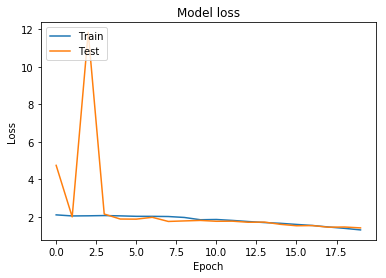

In [12]:
# Plot training & validation loss values
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

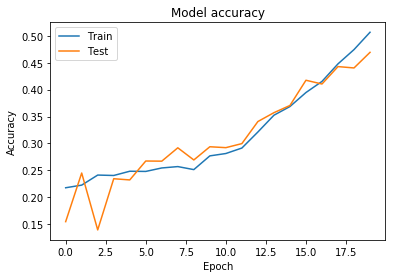

In [13]:
# Plot training & validation accuracy values
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
print("Training Accuracy is: ", np.mean(h.history['acc']))
print("Max Training Accuracy is: ", np.amax(h.history['acc']))
print("Validation Accuracy is: ", np.mean(h.history['val_acc']))
print("Max Validation Accuracy is: ", np.amax(h.history['val_acc']))

Training Accuracy is:  0.3156681528388421
Max Training Accuracy is:  0.5065019506183939
Validation Accuracy is:  0.31186960156696625
Max Validation Accuracy is:  0.46921147952906167


In [15]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

Anger


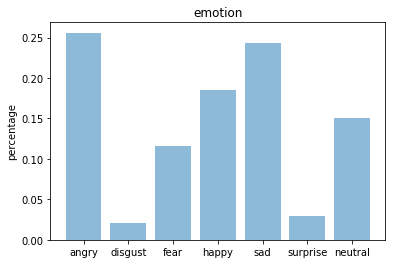

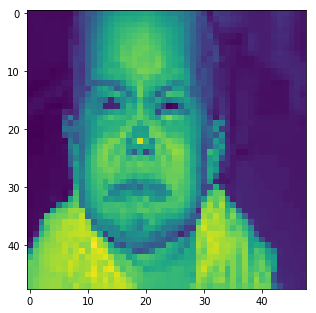

In [16]:
#from skimage import io
img = image.load_img('sad.jpg',color_mode='grayscale', target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
index, =np.where(custom[0]==max(custom[0])) 
emo = label_map[index[0]]
emotion_analysis(custom[0])
x = np.array(x, 'float32')
x = x.reshape([48, 48]);

#plt.gray()
plt.figure(figsize = (5,6))
plt.imshow(x)
print(emo)
plt.show()
